# **Import Libraries**

In [2]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-05-22 16:11:24.089381: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-22 16:11:24.089476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-22 16:11:24.259805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [1]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 3.2.1
    Uninstalling keras-3.2.1:
      Successfully uninstalled keras-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [3]:
print(tf.__version__)

2.15.0


# **Loading The Data**

In [4]:
train_csv = pd.read_csv("/kaggle/input/rsna-bone-age/boneage-training-dataset.csv")
train_csv.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [5]:
train_folder = os.listdir("/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset")
print(len(train_folder))

12611


## Adding image path to the dataframe

In [6]:
base_path = "/kaggle/input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset"

train_list_id = train_csv['id'].to_list()
train_csv['imagePath'] = [base_path + f"/{str(i)}.png" for i in train_list_id]

# Changing the male column values from True,False to 1 and 0
train_csv['male'] = train_csv['male'].replace({'False': 0, 'True': 1}).astype(int)

train_csv.head()

,id,boneage,male,imagePath
0,1377,180,0,/kaggle/input/rsna-bone-age/boneage-training-d...
1,1378,12,0,/kaggle/input/rsna-bone-age/boneage-training-d...
2,1379,94,0,/kaggle/input/rsna-bone-age/boneage-training-d...
3,1380,120,1,/kaggle/input/rsna-bone-age/boneage-training-d...
4,1381,82,0,/kaggle/input/rsna-bone-age/boneage-training-d...


### Describing the dataframe

In [7]:
train_csv.describe()

,id,boneage,male
count,12611.000000,12611.000000,12611.000000
mean,8537.653001,127.320752,0.541829
std,4108.763993,41.182021,0.498267
min,1377.000000,1.000000,0.000000
25%,5074.500000,96.000000,0.000000
50%,8565.000000,132.000000,1.000000
75%,12091.500000,156.000000,1.000000
max,15610.000000,228.000000,1.000000


## visualizing the distribution of Boneage and male column of the dataframe

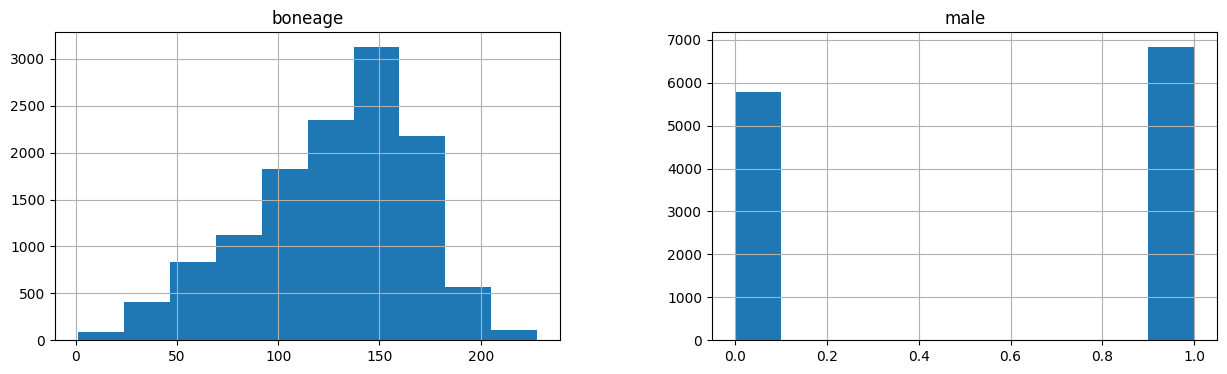

In [8]:
train_csv[['boneage', 'male']].hist(figsize=(15, 4))
plt.show()

## visualizing 4 samples whth according bonage value

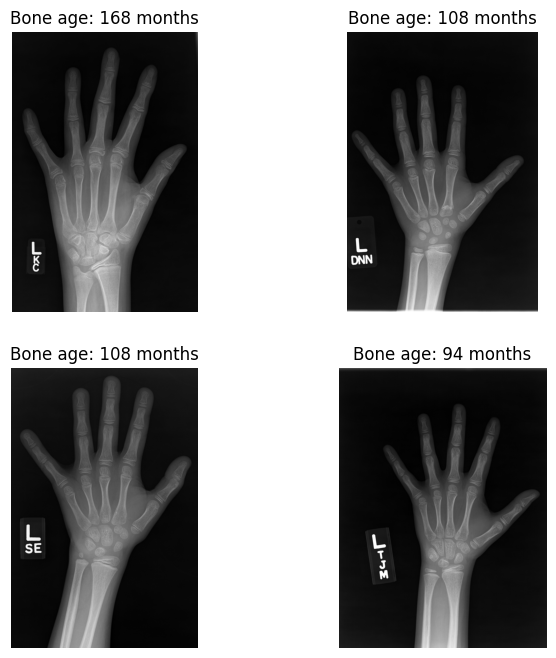

In [9]:
sample_data = train_csv[['boneage', 'imagePath']].sample(4).values

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8,8))

for i, (bone_age, img_path) in enumerate(sample_data):
    img = cv2.imread(img_path)
    axs[i // 2, i % 2].imshow(img)
    axs[i // 2, i % 2].set_title(f'Bone age: {bone_age} months')
    axs[i // 2, i % 2].axis('off')

plt.show()

# **Data Preprocessing**

## Scaling using StandardScaler

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()# **Data Preprocessing**
train_csv['scaled_boneage'] = scaler.fit_transform(train_csv[['boneage']])
train_csv.head()

,id,boneage,male,imagePath,scaled_boneage
0,1377,180,0,/kaggle/input/rsna-bone-age/boneage-training-d...,1.279231
1,1378,12,0,/kaggle/input/rsna-bone-age/boneage-training-d...,-2.800380
2,1379,94,0,/kaggle/input/rsna-bone-age/boneage-training-d...,-0.809141
3,1380,120,1,/kaggle/input/rsna-bone-age/boneage-training-d...,-0.177773
4,1381,82,0,/kaggle/input/rsna-bone-age/boneage-training-d...,-1.100542


## Splitting the dataset into validation and train

In [11]:
from sklearn.model_selection import train_test_split

# making subset to pass it to the train_test_split func as stratify:
# to ensure that the proportion of bone age values will remain consistent between validation and train dataset.
subsets = pd.cut(train_csv['boneage'], 19)

train_df, valid_df = train_test_split(train_csv,
                                      test_size=0.20,
                                      random_state=46,
                                      stratify=subsets)
print('train', train_df.shape, 'validation', valid_df.shape)

train (10088, 5) validation (2523, 5)


## Xception model input data generator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input

train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
val_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

img_size = 256
batch_size = 32

# train data generator
train_generator = train_data_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imagePath',
    y_col='scaled_boneage',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='other',
    flip_vertical=True,
    color_mode='rgb',
    target_size=(img_size, img_size))

# validation data generator
val_generator = val_data_generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imagePath',
    y_col='scaled_boneage',
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode='other',
    flip_vertical=True,
    color_mode='rgb',
    target_size=(img_size, img_size))

Found 10088 validated image filenames.
Found 2523 validated image filenames.


## MAE to month convertor

In [24]:
from keras.metrics import mean_absolute_error
from keras.saving import register_keras_serializable

mean_boneage = train_csv['boneage'].mean()
std_boneage = train_csv['boneage'].std()

@register_keras_serializable()
def mae_to_months(x_predicted, y_predicted):
    return mean_absolute_error((std_boneage * x_predicted + mean_boneage),
                               (std_boneage * y_predicted + mean_boneage))

print(std_boneage, mean_boneage)


41.182021399396326 127.3207517246848


# **Building model Architecture**

## Loading Xception architecture

In [14]:
from keras.applications.xception import Xception

Xception_model = Xception(input_shape=(img_size, img_size, 3),
                 include_top=False,
                 weights='imagenet')
Xception_model.save('xception_model.h5')

83683744/83683744 [==============================] - 0s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Adding layers to Xception model 

In [15]:
from keras.models import load_model
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, Flatten
from tensorflow.keras import Sequential


model0 = load_model('/kaggle/working/xception_model.h5')

model0.trainable = True
model = Sequential()
model.add(model0)
model.add(GlobalMaxPooling2D())
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear'))

#compile model
model.compile(loss='mse', optimizer='adam', metrics=[mae_to_months])

#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20881981 (79.66 MB)
Trainable params: 20827453 (79.45 MB)
Non-trainable params: 54528 (213.00 KB)
__________

# **Wandb Initialization**

In [16]:
!pip3 install wandb

In [17]:
import wandb

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Wandb configuration

In [18]:
run = wandb.init(
    project="RSNA_BoneAga_Trained",
    # Track hyperparameters and run metadata
    config={
        # "learning_rate": 0.01,
        "epochs": 15,
        "image_size": img_size,
        "batch_size": batch_size,

    },
)

STEP_SIZE_TRAIN = np.ceil(train_generator.n//run.config.batch_size)
STEP_SIZE_VALID = np.ceil(val_generator.n//run.config.batch_size)

wandb: Currently logged in as: hamed-hamze2212 (hamedo). Use `wandb login --relogin` to force relogin


## Initializing required callbacks

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
# from wandb.keras import WandbCallback


#early stopping
early_stopping = EarlyStopping(monitor='mae_to_months',
                              min_delta=0,
                              patience= 5,
                              verbose=0, mode='auto')

#model checkpoint
model_checkpoint = ModelCheckpoint('best_model_trained.keras', monitor='mae_to_months', mode='min', save_best_only=True)


#reduce lr on plateau
red_lr_plat = ReduceLROnPlateau(monitor='mae_to_months', factor=0.1, patience=10, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

#wandb
wandb_callback = wandb.keras.WandbCallback()


callbacks = [wandb_callback , early_stopping, model_checkpoint, red_lr_plat]

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


In [20]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = val_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = run.config.epochs,
                    callbacks= callbacks)

/tmp/ipykernel_34/3972360659.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/15


I0000 00:00:1716394479.430652     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


315/315 [==============================] - ETA: 0s - loss: 0.5233 - mae_to_months: 22.4018

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240522_161351-rny3k9q4/files/model-best)... Done. 1.0s


315/315 [==============================] - 657s 2s/step - loss: 0.5233 - mae_to_months: 22.4018 - val_loss: 0.1852 - val_mae_to_months: 14.1931 - lr: 0.0010
Epoch 2/15
315/315 [==============================] - 396s 1s/step - loss: 0.1491 - mae_to_months: 12.4565 - val_loss: 0.2125 - val_mae_to_months: 15.2929 - lr: 0.0010
Epoch 3/15
315/315 [==============================] - ETA: 0s - loss: 0.1161 - mae_to_months: 11.0521

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240522_161351-rny3k9q4/files/model-best)... Done. 1.0s


315/315 [==============================] - 408s 1s/step - loss: 0.1161 - mae_to_months: 11.0521 - val_loss: 0.1499 - val_mae_to_months: 12.4352 - lr: 0.0010
Epoch 4/15
315/315 [==============================] - 391s 1s/step - loss: 0.0859 - mae_to_months: 9.5351 - val_loss: 0.1521 - val_mae_to_months: 12.9957 - lr: 0.0010
Epoch 5/15
315/315 [==============================] - ETA: 0s - loss: 0.0677 - mae_to_months: 8.4324

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240522_161351-rny3k9q4/files/model-best)... Done. 1.0s


315/315 [==============================] - 408s 1s/step - loss: 0.0677 - mae_to_months: 8.4324 - val_loss: 0.1216 - val_mae_to_months: 11.3187 - lr: 0.0010
Epoch 6/15
315/315 [==============================] - 390s 1s/step - loss: 0.0530 - mae_to_months: 7.4084 - val_loss: 0.1467 - val_mae_to_months: 12.3650 - lr: 0.0010
Epoch 7/15
315/315 [==============================] - ETA: 0s - loss: 0.0506 - mae_to_months: 7.2429

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240522_161351-rny3k9q4/files/model-best)... Done. 1.0s


315/315 [==============================] - 413s 1s/step - loss: 0.0506 - mae_to_months: 7.2429 - val_loss: 0.1094 - val_mae_to_months: 10.5029 - lr: 0.0010
Epoch 8/15
315/315 [==============================] - 389s 1s/step - loss: 0.0371 - mae_to_months: 6.2193 - val_loss: 0.1169 - val_mae_to_months: 10.9889 - lr: 0.0010
Epoch 9/15
315/315 [==============================] - 388s 1s/step - loss: 0.0347 - mae_to_months: 6.0214 - val_loss: 0.1418 - val_mae_to_months: 12.1551 - lr: 0.0010
Epoch 10/15
315/315 [==============================] - ETA: 0s - loss: 0.0300 - mae_to_months: 5.6171

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/kaggle/working/wandb/run-20240522_161351-rny3k9q4/files/model-best)... Done. 1.0s


315/315 [==============================] - 411s 1s/step - loss: 0.0300 - mae_to_months: 5.6171 - val_loss: 0.0930 - val_mae_to_months: 9.7358 - lr: 0.0010
Epoch 11/15
315/315 [==============================] - 388s 1s/step - loss: 0.0251 - mae_to_months: 5.0871 - val_loss: 0.0974 - val_mae_to_months: 9.8603 - lr: 0.0010
Epoch 12/15
315/315 [==============================] - 387s 1s/step - loss: 0.0234 - mae_to_months: 4.9395 - val_loss: 0.0938 - val_mae_to_months: 9.7127 - lr: 0.0010
Epoch 13/15
315/315 [==============================] - 388s 1s/step - loss: 0.0257 - mae_to_months: 5.0447 - val_loss: 0.1311 - val_mae_to_months: 11.6858 - lr: 0.0010
Epoch 14/15
315/315 [==============================] - 387s 1s/step - loss: 0.0507 - mae_to_months: 6.8919 - val_loss: 0.9196 - val_mae_to_months: 30.2317 - lr: 0.0010
Epoch 15/15
315/315 [==============================] - 388s 1s/step - loss: 0.0803 - mae_to_months: 8.9869 - val_loss: 0.1206 - val_mae_to_months: 11.1836 - lr: 0.0010


# **Testing the best model**

In [25]:
RSNA_Xception_model = load_model ("/kaggle/working/best_model_trained.keras",
                                  custom_objects={'mae_to_months': mae_to_months})

In [34]:
evaluation = RSNA_Xception_model.evaluate_generator(val_generator)
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

/tmp/ipykernel_34/3364278984.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluation = RSNA_Xception_model.evaluate_generator(val_generator)


Validation Loss: 0.09356788545846939
Validation Accuracy: 9.703176498413086


## Creating Test data generator

In [27]:
test_img_path = ('../input/rsna-bone-age/boneage-test-dataset/')
test_images = os.listdir(test_img_path)

pred_datagen = ImageDataGenerator(rescale=1./255)
pred_generator = pred_datagen.flow_from_directory(
        str(test_img_path) ,#"../input/rsna-bone-age/boneage-test-dataset/boneage-test-dataset/",
        target_size=(224, 224),
        batch_size=10,
        class_mode='sparse',
        color_mode ='rgb',
        shuffle=False)

Found 200 images belonging to 1 classes.


## Model prediction on test set

In [28]:
img_batch = next(pred_generator)
pred = RSNA_Xception_model.predict_generator(pred_generator, steps=len(pred_generator), verbose=1)

/tmp/ipykernel_34/1224868889.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = RSNA_Xception_model.predict_generator(pred_generator, steps=len(pred_generator), verbose=1)


20/20 [==============================] - 6s 267ms/step


In [29]:
cl = np.round(pred)
filenames=pred_generator.filenames
y_months = (pred[:,0] * std_boneage + mean_boneage).astype(int)


## Saving prediction in CSV Format

In [30]:
results=pd.DataFrame({"file":filenames,"prediction":y_months})

In [31]:
results.head(5)

,file,prediction
0,boneage-test-dataset/4360.png,146
1,boneage-test-dataset/4361.png,149
2,boneage-test-dataset/4362.png,53
3,boneage-test-dataset/4363.png,136
4,boneage-test-dataset/4364.png,122


In [33]:
results.to_csv("boneage_testdata_predict.csv")